In [28]:
import sys
import os
import json
import matplotlib.pyplot as plt

import dysts
from dysts.datasets import *

from dysts.flows import *
from dysts.base import *
from dysts.utils import *
from dysts.analysis import *

from darts.models import *
from darts import TimeSeries
import darts.models

# try:
#     from private.lyap import lyap_r, lyap_e, corr_dim
# except:
#     from nolds import lyap_r, lyap_e, corr_dim

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [27]:
ee = kwarg_vals.copy()

ee["season_mode"] = 60

kwarg_vals

{'season_mode': 5}

In [21]:
#!/usr/bin/python

import sys
import os
import json

# import dysts
from dysts.datasets import *

import pandas as pd

from darts.models import *
from darts import TimeSeries
import darts.models

pts_per_period = 100
season_values = [darts.utils.utils.SeasonalityMode.ADDITIVE, darts.utils.utils.SeasonalityMode.NONE]
time_delays = [3, 5, 10, int(0.25 * pts_per_period), int(0.5 * pts_per_period), pts_per_period, int(1.5 * pts_per_period)]
time_delays = [3, 5, int(0.25 * pts_per_period)]
time_delays = [1, 5, 10, 25]


time_models = {
    'ARIMA': {"p": 10},
#     'LinearRegressionModel' : {"lags": 10},
#     'NBEATSModel' : {"input_chunk_length": 40, "output_chunk_length": 1},
    'RandomForest' : {"lags": 10, "lags_exog": None},
#     'TCNModel' : {"input_chunk_length": 40, "output_chunk_length": 1},
#     "TransformerModel" :  {"input_chunk_length": 100, "output_chunk_length": 1},
}

seasonality_models = {
    'ExponentialSmoothing' : {"seasonal": darts.utils.utils.SeasonalityMode.ADDITIVE},
    'FourTheta' : {"season_mode": darts.utils.utils.SeasonalityMode.ADDITIVE},
    'Theta' : {"season_mode": darts.utils.utils.SeasonalityMode.ADDITIVE},
}

null_models = ["AutoARIMA", "FFT", "NaiveDrift", "NaiveMean", "NaiveSeasonal", "Prophet"]


cwd = os.getcwd()
# cwd = os.path.dirname(os.path.realpath(__file__))
input_path = os.path.dirname(cwd)  + "/dysts/data/train_univariate__pts_per_period_100__periods_12.json"
dataname = os.path.splitext(os.path.basename(os.path.split(input_path)[-1]))[0]
output_path = "./hyperparameters/hyperparameters_" + dataname + ".json"

equation_data = load_file(input_path)



all_hyperparameters = dict()
# for equation_name in equation_data.dataset:
for equation_name in ["Aizawa", "SprottB"]:
    
#     if equation_name in all_hyperparameters.keys():
#         continue
    
    print(equation_name)
    train_data = np.array(equation_data.dataset[equation_name]["values"])
    all_hyperparameters[equation_name] = dict()
    
    split_point = int(5/6 * len(train_data))
    y_train, y_val = train_data[:split_point], train_data[split_point:]
    
#     plt.figure()
#     plt.plot(y_val)
    
    for model_name in time_models:
        print("\t" + model_name)
        all_scores = list()
        for tau in time_delays:
            kwarg_vals = time_models[model_name]
            kwarg_vals[list(kwarg_vals.keys())[0]] = tau
            model = getattr(darts.models, model_name)(**kwarg_vals)
            
            y_train_ts = TimeSeries.from_dataframe(pd.DataFrame(y_train))
            model.fit(y_train_ts)
            y_val_pred = model.predict(len(y_val))
            
#             plt.plot(np.squeeze(y_val_pred.values()))

            pred_y = TimeSeries.from_dataframe(pd.DataFrame(np.squeeze(y_val_pred.values())))
            true_y = TimeSeries.from_dataframe(pd.DataFrame(np.squeeze(y_val)[:-1]))

            all_scores.append(darts.metrics.mse(true_y, pred_y))
        print("\t", np.argmin(all_scores))
        print("\t", all_scores)
        best_tau = time_delays[np.argmin(all_scores)]
        kwarg_vals = time_models[model_name].copy()
        kwarg_vals[list(kwarg_vals.keys())[0]] = best_tau
        all_hyperparameters[equation_name][model_name] = kwarg_vals.copy()
        print("\t", equation_name, model_name)
        
    ## These models don't require hyperparameter tuning
    for model_name in null_models:
        all_hyperparameters[equation_name][model_name] = {}


    ## Tune seasonality parameter      
    for model_name in seasonality_models:
        all_scores = list()
        for season in season_values:
            kwarg_vals = seasonality_models[model_name]
            kwarg_vals[list(kwarg_vals.keys())[0]] = season
            model = getattr(darts.models, model_name)(**kwarg_vals)
            
            y_train_ts = TimeSeries.from_dataframe(pd.DataFrame(y_train))
            model.fit(y_train_ts)
            y_val_pred = model.predict(len(y_val))

            pred_y = TimeSeries.from_dataframe(pd.DataFrame(np.squeeze(y_val_pred.values())))
            true_y = TimeSeries.from_dataframe(pd.DataFrame(np.squeeze(y_val)[:-1]))

            all_scores.append(darts.metrics.mse(true_y, pred_y))
        best_season = season_values[np.argmin(all_scores)]
        kwarg_vals = seasonality_models[model_name].copy()
        kwarg_vals[list(kwarg_vals.keys())[0]] = best_season.name
        all_hyperparameters[equation_name][model_name] = kwarg_vals.copy()
        
    with open(output_path, 'w') as f:
        json.dump(all_hyperparameters, f, indent=4)   
    

Aizawa
	ARIMA


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


	 3
	 [0.6432829063920672, 0.517761894645782, 0.15688563119640073, 0.12370369689350617]
	 Aizawa ARIMA
	RandomForest
	 2
	 [2.4246871442368474, 0.16521528968339547, 0.03645291889536528, 0.06146594085545893]
	 Aizawa RandomForest


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
[2021-06-14 07:38:06,579] INFO | darts.models.theta | FourTheta model inferred seasonality of training series: 68
[2021-06-14 07:38:06,579] INFO | darts.models.theta | FourTheta model inferred seasonality of training series: 68
[2021-06-14 07:38:06,588] WARNING | darts.models.theta | Time series has negative values. Fallback to additive and linear model
[2021-06-14 07:38:06,588] WARNING | darts.models.theta | Time series has negative values. Fallback to additive and linear model
[2021-06-14 07:38:06,649] WARNING | darts.models.theta | Time series has negative values. Fallback to additive and linear model
[2021-06-14 07:38:06,649] WARNING | darts.models.theta | Time series has negative values. Fallback to additive and linear model
[2021-06-14 07:38:06,710] INFO | darts.models.theta | Thet

SprottB
	ARIMA
	 3
	 [2.225127427952089, 1.941119965945138, 1.9221809985827722, 1.8786106968900782]
	 SprottB ARIMA
	RandomForest
	 0
	 [1.867606053423733, 3.588240507960872, 2.383230143032103, 2.3614987305629556]
	 SprottB RandomForest


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
[2021-06-14 07:38:30,043] INFO | darts.models.theta | FourTheta model inferred seasonality of training series: 167
[2021-06-14 07:38:30,043] INFO | darts.models.theta | FourTheta model inferred seasonality of training series: 167
[2021-06-14 07:38:30,059] WARNING | darts.models.theta | Time series has negative values. Fallback to additive and linear model
[2021-06-14 07:38:30,059] WARNING | darts.models.theta | Time series has negative values. Fallback to additive and linear model
[2021-06-14 07:38:30,132] WARNING | darts.models.theta | Time series has negative values. Fallback to additive and linear model
[2021-06-14 07:38:30,132] WARNING | darts.models.theta | Time series has negative values. Fallback to additive and linear model
[2021-06-14 07:38:30,205] INFO | darts.models.theta | Th

In [ ]:
%%bash
python3 find_hyperparameters.py > log.txt &

In [6]:



# from darts.models import ExponentialSmoothing

# model = ExponentialSmoothing()
# model.fit(train)
# prediction = model.predict(len(val))

In [104]:
all_model_names = [
        'ARIMA',
        'AutoARIMA',
        'ExponentialSmoothing',
        'FFT',
        'FourTheta',
        'LinearRegressionModel',
        'NBEATSModel',
        'NaiveDrift',
        'NaiveEnsembleModel',
        'NaiveMean',
        'NaiveSeasonal',
        'Prophet',
        'RNNModel',
        'RandomForest',
        'TCNModel',
        'Theta',
        'TransformerModel',
        'VARIMA']

### Tune hyperparameters on train

In [106]:
hyperparameters = {"lags": 10, "lags_exog": 10}
darts.models.RandomForest(**hyperparameters)

In [54]:
time_models = {
    'ARIMA': {"p": 10},
    'LinearRegressionModel' : {"lags": 10},
#     'NBEATSModel' : {"input_chunk_length": 40, "output_chunk_length": 1},
    'RandomForest' : {"lags": 10, "lags_exog": None},
#     'TCNModel' : {"input_chunk_length": 40, "output_chunk_length": 1},
#     "TransformerModel" :  {"input_chunk_length": 100, "output_chunk_length": 1},
}

In [55]:
time_models[model_name]

{'lags': 10, 'lags_exog': None}

In [65]:

kwarg_vals

{'lags': 1, 'lags_exog': None}

In [58]:
model.lags

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50]

In [90]:
darts.utils.utils.SeasonalityMode.ADDITIVE

<SeasonalityMode.ADDITIVE: 'additive'>

In [98]:
output_path

'./hyperparameters/hyperparameters_train_univariate__pts_per_period_100__periods_12.json'

In [22]:
# import sys
# import os
# import json

# # import dysts
# from dysts.datasets import *

# # from dysts.flows import *
# # from dysts.base import *
# # from dysts.utils import *
# # from dysts.analysis import *

# import pandas as pd

# from darts.models import *
# from darts import TimeSeries
# import darts.models

# pts_per_period = 100
# season_values = [darts.utils.utils.SeasonalityMode.ADDITIVE, darts.utils.utils.SeasonalityMode.NONE]
# time_delays = [1, 5, int(0.25 * pts_per_period), int(0.5 * pts_per_period), pts_per_period, int(1.5 * pts_per_period)]
# time_delays = [3, 5, int(0.25 * pts_per_period)]

# time_models = {
#     'ARIMA': {"p": 10},
# #     'LinearRegressionModel' : {"lags": 10},
# #     'NBEATSModel' : {"input_chunk_length": 40, "output_chunk_length": 1},
#     'RandomForest' : {"lags": 10, "lags_exog": None},
# #     'TCNModel' : {"input_chunk_length": 40, "output_chunk_length": 1},
# #     "TransformerModel" :  {"input_chunk_length": 100, "output_chunk_length": 1},
# }

# seasonality_models = {
#     'ExponentialSmoothing' : {"seasonal": darts.utils.utils.SeasonalityMode.ADDITIVE},
#     'FourTheta' : {"season_mode": darts.utils.utils.SeasonalityMode.ADDITIVE},
#     'Theta' : {"season_mode": darts.utils.utils.SeasonalityMode.ADDITIVE},
# }

# null_models = ["AutoARIMA", "FFT", "NaiveDrift", "NaiveMean", "NaiveSeasonal", "Prophet"]


# cwd = os.getcwd()
# input_path = os.path.dirname(cwd)  + "/dysts/data/train_univariate__pts_per_period_100__periods_12.json"
# dataname = os.path.splitext(os.path.basename(os.path.split(input_path)[-1]))[0]
# output_path = "./hyperparameters/hyperparameters_" + dataname + ".json"

# equation_data = load_file(input_path)



# all_hyperparameters = dict()
# for equation_name in equation_data.dataset:
#     print(equation_name)
#     train_data = np.array(equation_data.dataset[equation_name]["values"])
#     all_hyperparameters[equation_name] = dict()
    
#     split_point = int(5/6 * len(train_data))
#     y_train, y_val = train_data[:split_point], train_data[split_point:]
    
#     for model_name in time_models:
#         print("\t" + model_name)
#         all_scores = list()
#         for tau in time_delays:
#             kwarg_vals = time_models[model_name]
#             kwarg_vals[list(kwarg_vals.keys())[0]] = tau
#             model = getattr(darts.models, model_name)(**kwarg_vals)
            
#             y_train_ts = TimeSeries.from_dataframe(pd.DataFrame(y_train))
#             model.fit(y_train_ts)
#             y_val_pred = model.predict(len(y_val))

#             pred_y = TimeSeries.from_dataframe(pd.DataFrame(np.squeeze(y_val_pred.values())))
#             true_y = TimeSeries.from_dataframe(pd.DataFrame(np.squeeze(y_val)[:-1]))

#             all_scores.append(darts.metrics.mse(true_y, pred_y))
#         best_tau = time_delays[np.argmin(all_scores)]
#         kwarg_vals = time_models[model_name]
#         kwarg_vals[list(kwarg_vals.keys())[0]] = best_tau
#         all_hyperparameters[equation_name][model_name] = kwarg_vals
        
#     ## These models don't require hyperparameter tuning
#     for model_name in null_models:
#         all_hyperparameters[equation_name][model_name] = {}


#     ## Tune seasonality parameter      
#     for model_name in seasonality_models:
#         all_scores = list()
#         for season in season_values:
#             kwarg_vals = seasonality_models[model_name]
#             kwarg_vals[list(kwarg_vals.keys())[0]] = season
#             model = getattr(darts.models, model_name)(**kwarg_vals)
            
#             y_train_ts = TimeSeries.from_dataframe(pd.DataFrame(y_train))
#             model.fit(y_train_ts)
#             y_val_pred = model.predict(len(y_val))

#             pred_y = TimeSeries.from_dataframe(pd.DataFrame(np.squeeze(y_val_pred.values())))
#             true_y = TimeSeries.from_dataframe(pd.DataFrame(np.squeeze(y_val)[:-1]))

#             all_scores.append(darts.metrics.mse(true_y, pred_y))
#         best_season = season_values[np.argmin(all_scores)]
#         kwarg_vals = seasonality_models[model_name]
#         kwarg_vals[list(kwarg_vals.keys())[0]] = best_season.name
#         all_hyperparameters[equation_name][model_name] = kwarg_vals
        
#     with open(output_path, 'w') as f:
#         json.dump(all_hyperparameters, f, indent=4)   
    

Aizawa
	ARIMA


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


	RandomForest


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
[2021-06-13 03:50:56,826] INFO | darts.models.theta | FourTheta model inferred seasonality of training series: 68
[2021-06-13 03:50:56,826] INFO | darts.models.theta | FourTheta model inferred seasonality of training series: 68
[2021-06-13 03:50:56,837] WARNING | darts.models.theta | Time series has negative values. Fallback to additive and linear model
[2021-06-13 03:50:56,837] WARNING | darts.models.theta | Time series has negative values. Fallback to additive and linear model
[2021-06-13 03:50:56,907] WARNING | darts.models.theta | Time series has negative values. Fallback to additive and linear model
[2021-06-13 03:50:56,907] WARNING | darts.models.theta | Time series has negative values. Fallback to additive and linear model
[2021-06-13 03:50:56,977] INFO | darts.models.theta | Thet

AnishchenkoAstakhov
	ARIMA


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


	RandomForest


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
[2021-06-13 03:51:15,987] INFO | darts.models.theta | FourTheta model inferred seasonality of training series: 92
[2021-06-13 03:51:15,987] INFO | darts.models.theta | FourTheta model inferred seasonality of training series: 92
[2021-06-13 03:51:15,999] WARNING | darts.models.theta | Time series has negative values. Fallback to additive and linear model
[2021-06-13 03:51:15,999] WARNING | darts.models.theta | Time series has negative values. Fallback to additive and linear model
[2021-06-13 03:51:16,065] WARNING | darts.models.theta | Time series has negative values. Fallback to additive and linear model
[2021-06-13 03:51:16,065] WARNING | darts.models.theta | Time series has negative values. Fallback to additive and linear model
[2021-06-13 03:51:16,126] INFO | darts.models.theta | Thet

Arneodo
	ARIMA


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


	RandomForest


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
[2021-06-13 03:51:39,536] INFO | darts.models.theta | FourTheta model inferred seasonality of training series: 91
[2021-06-13 03:51:39,536] INFO | darts.models.theta | FourTheta model inferred seasonality of training series: 91
[2021-06-13 03:51:39,546] WARNING | darts.models.theta | Time series has negative values. Fallback to additive and linear model
[2021-06-13 03:51:39,546] WARNING | darts.models.theta | Time series has negative values. Fallback to additive and linear model
[2021-06-13 03:51:39,616] WARNING | darts.models.theta | Time series has negative values. Fallback to additive and linear model
[2021-06-13 03:51:39,616] WARNING | darts.models.theta | Time series has negative values. Fallback to additive and linear model
[2021-06-13 03:51:39,683] INFO | darts.models.theta | Thet

ArnoldBeltramiChildress
	ARIMA


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


	RandomForest


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
[2021-06-13 03:52:01,643] INFO | darts.models.theta | FourTheta model inferred seasonality of training series: 126
[2021-06-13 03:52:01,643] INFO | darts.models.theta | FourTheta model inferred seasonality of training series: 126
[2021-06-13 03:52:01,657] WARNING | darts.models.theta | Time series has negative values. Fallback to additive and linear model
[2021-06-13 03:52:01,657] WARNING | darts.models.theta | Time series has negative values. Fallback to additive and linear model
[2021-06-13 03:52:01,728] WARNING | darts.models.theta | Time series has negative values. Fallback to additive and linear model
[2021-06-13 03:52:01,728] WARNING | darts.models.theta | Time series has negative values. Fallback to additive and linear model
[2021-06-13 03:52:01,798] INFO | darts.models.theta | Th

ArnoldWeb
	ARIMA


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


	RandomForest


KeyboardInterrupt: 

In [21]:
best_season

<SeasonalityMode.ADDITIVE: 'additive'>

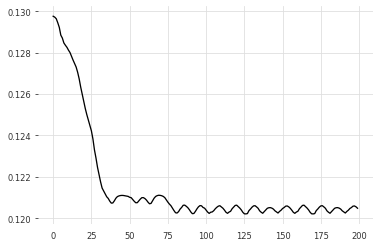

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(pred_y.values())

In [20]:
all_scores

[3.179583794960312, 3.740036385649604]

In [24]:
all_hyperparameters

{'Aizawa': {'ARIMA': {'p': 25},
  'RandomForest': {'lags': 5, 'lags_exog': None},
  'AutoARIMA': {},
  'FFT': {},
  'NaiveDrift': {},
  'NaiveMean': {},
  'NaiveSeasonal': {},
  'Prophet': {},
  'ExponentialSmoothing': {'seasonal': 'ADDITIVE'},
  'FourTheta': {'season_mode': 'NONE'},
  'Theta': {'season_mode': 'NONE'}},
 'AnishchenkoAstakhov': {'ARIMA': {'p': 25},
  'RandomForest': {'lags': 5, 'lags_exog': None},
  'AutoARIMA': {},
  'FFT': {},
  'NaiveDrift': {},
  'NaiveMean': {},
  'NaiveSeasonal': {},
  'Prophet': {},
  'ExponentialSmoothing': {'seasonal': 'ADDITIVE'},
  'FourTheta': {'season_mode': 'NONE'},
  'Theta': {'season_mode': 'NONE'}},
 'Arneodo': {'ARIMA': {'p': 25},
  'RandomForest': {'lags': 5, 'lags_exog': None},
  'AutoARIMA': {},
  'FFT': {},
  'NaiveDrift': {},
  'NaiveMean': {},
  'NaiveSeasonal': {},
  'Prophet': {},
  'ExponentialSmoothing': {'seasonal': 'ADDITIVE'},
  'FourTheta': {'season_mode': 'NONE'},
  'Theta': {'season_mode': 'NONE'}},
 'ArnoldBeltramiChil

In [36]:
all_hyperparameters

{'Aizawa': {'ARIMA': 1, 'LinearRegressionModel': 1, 'RandomForest': 1},
 'AnishchenkoAstakhov': {'ARIMA': 1,
  'LinearRegressionModel': 1,
  'RandomForest': 1},
 'Arneodo': {'ARIMA': 1, 'LinearRegressionModel': 1, 'RandomForest': 1}}

In [ ]:
np.array(all_scores)

In [19]:
equation_data.to_array().shape

(131, 1200)

In [ ]:
pred_y = TimeSeries.from_dataframe(pd.DataFrame(np.array(all_predictions["TransformerModel"])))
true_y = TimeSeries.from_dataframe(pd.DataFrame(y_train_val[:-1]))

for metric_name in all_metrics:
    if metric_name == "mase":
        metric_func = lambda x, y : darts.metrics.metrics.mase(x, y, insample=train_ts)
    else:

In [ ]:
all_hyperparameters = dict()


seasonality_modes = [darts.utils.utils.SeasonalityMode.ADDITIVE, darts.utils.utils.SeasonalityMode.None]


# TCN
kernel_sizes = [3, 5]
num_layers = [3, 5, 10]

# NBeats
num_blocks = [1, 4]
num_layers = [2, 4, 8]

# Forest

n_estimators = [50, 100, 200]


In [5]:
equation_data = load_file(os.path.dirname(cwd)  + "/dysts/data/train_univariate__pts_per_period_100__periods_12.json")

### Tune calculate predictions on test

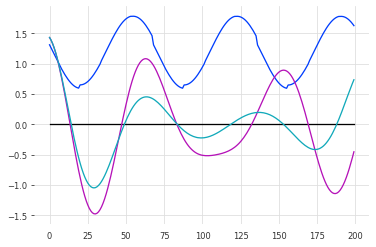

In [6]:
for item in all_results["Aizawa"]:
    plt.plot(all_results["Aizawa"][item])

In [5]:

import darts
import darts.models
import json



all_models = {
#     'ARIMA': {"p": 10},
    'AutoARIMA' : {},
#     'ExponentialSmoothing' : {"seasonal": darts.utils.utils.SeasonalityMode.ADDITIVE},
#     'FFT' : {},
    'FourTheta' : {"season_mode": darts.utils.utils.SeasonalityMode.ADDITIVE},
    'LinearRegressionModel' : {"lags": 10},
#     'NaiveDrift' : {},
#     'NaiveMean' : {},
#     'NaiveSeasonal' : {},
#     'NBEATSModel' : {"input_chunk_length": 40, "output_chunk_length": 1},
#     'Prophet' : {},
#     'RandomForest' : {"lags": 10, "lags_exog": None},
#     'TCNModel' : {"input_chunk_length": 40, "output_chunk_length": 1},
#     'Theta' : {"season_mode": darts.utils.utils.SeasonalityMode.ADDITIVE},
#     "TransformerModel" :  {"input_chunk_length": 100, "output_chunk_length": 1},
}


cwd = os.getcwd()
input_path = os.path.dirname(cwd)  + "/dysts/data/train_univariate__pts_per_period_100__periods_12.json"
output_path = "./results/univariate_predictions.json"


# train_data = load_file(os.path.dirname(cwd)  + "/dysts/data/train_univariate__pts_per_period_100__periods_12.json").to_array()[0]
# test_data = load_file(os.path.dirname(cwd) + "/dysts/data/test_univariate__pts_per_period_100__periods_12.json").to_array()[0]
# split_point = int(5/6 * len(train_data))


equation_data = load_file(input_path)

all_results = dict()
for equation_name in equation_data.dataset:
    print(equation_name)
    train_data = np.array(equation_data.dataset[equation_name]["values"])
    split_point = int(5/6 * len(train_data))

    all_predictions = dict()
    for model_name in all_models:
        print("\t" + model_name)
#         all_predictions[model_name] = dict()
        model = getattr(darts.models, model_name)(**all_models[model_name])

        y_train, y_val = train_data[:split_point], train_data[split_point:]
        y_train_ts = TimeSeries.from_dataframe(pd.DataFrame(y_train))
        model.fit(y_train_ts)
        prediction = model.predict(len(y_val))
        all_predictions[f"y_pred_val_{model_name}"] = np.squeeze(prediction.values()).tolist()
    all_predictions["y_train_val"] = np.squeeze(y_val).tolist()
    
    all_results[equation_name] = all_predictions
    with open(output_path, 'w') as f:
        json.dump(all_results, f, indent=4)   

Aizawa
	AutoARIMA


[2021-06-12 06:33:45,938] INFO | darts.models.theta | FourTheta model inferred seasonality of training series: 68
[2021-06-12 06:33:45,938] INFO | darts.models.theta | FourTheta model inferred seasonality of training series: 68
[2021-06-12 06:33:45,947] WARNING | darts.models.theta | Time series has negative values. Fallback to additive and linear model
[2021-06-12 06:33:45,947] WARNING | darts.models.theta | Time series has negative values. Fallback to additive and linear model


	FourTheta
	LinearRegressionModel


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


AnishchenkoAstakhov
	AutoARIMA


[2021-06-12 06:34:02,731] INFO | darts.models.theta | FourTheta model inferred seasonality of training series: 92
[2021-06-12 06:34:02,731] INFO | darts.models.theta | FourTheta model inferred seasonality of training series: 92
[2021-06-12 06:34:02,742] WARNING | darts.models.theta | Time series has negative values. Fallback to additive and linear model
[2021-06-12 06:34:02,742] WARNING | darts.models.theta | Time series has negative values. Fallback to additive and linear model


	FourTheta
	LinearRegressionModel


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Arneodo
	AutoARIMA


[2021-06-12 06:34:07,807] INFO | darts.models.theta | FourTheta model inferred seasonality of training series: 91
[2021-06-12 06:34:07,807] INFO | darts.models.theta | FourTheta model inferred seasonality of training series: 91
[2021-06-12 06:34:07,817] WARNING | darts.models.theta | Time series has negative values. Fallback to additive and linear model
[2021-06-12 06:34:07,817] WARNING | darts.models.theta | Time series has negative values. Fallback to additive and linear model


	FourTheta
	LinearRegressionModel


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


ArnoldBeltramiChildress
	AutoARIMA


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/pmdarima/arima/_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(2,1,2)(0,0,0)[0]           (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/pmdarima/arima/_auto_solvers.py", line 506, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/pmdarima/arima/arima.py", line 482, in fit
    self._fit(y, X, **fit_args)
  File "/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/pmdarima/arima/arima.py", line 403, in _fit
    fit, self.arima_res_ = _fit_wrapper()
  File "/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/pmdarima/arima/arima.py", line 393, in _fit_wrapper
    return arima, arima.fit(start_params=start_params,
  File "/Users/williamgilpin/minic

	FourTheta
	LinearRegressionModel


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


ArnoldWeb
	AutoARIMA


[2021-06-12 06:34:37,507] INFO | darts.models.theta | FourTheta model inferred seasonality of training series: 77
[2021-06-12 06:34:37,507] INFO | darts.models.theta | FourTheta model inferred seasonality of training series: 77


	FourTheta
	LinearRegressionModel


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


BeerRNN
	AutoARIMA


[2021-06-12 06:34:50,570] INFO | darts.models.theta | FourTheta model inferred seasonality of training series: 77
[2021-06-12 06:34:50,570] INFO | darts.models.theta | FourTheta model inferred seasonality of training series: 77
[2021-06-12 06:34:50,581] WARNING | darts.models.theta | Time series has negative values. Fallback to additive and linear model
[2021-06-12 06:34:50,581] WARNING | darts.models.theta | Time series has negative values. Fallback to additive and linear model


	FourTheta
	LinearRegressionModel


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


BelousovZhabotinsky
	AutoARIMA


[2021-06-12 06:34:56,583] INFO | darts.models.theta | FourTheta model inferred seasonality of training series: 103
[2021-06-12 06:34:56,583] INFO | darts.models.theta | FourTheta model inferred seasonality of training series: 103
[2021-06-12 06:34:56,595] WARNING | darts.models.theta | Time series has negative values. Fallback to additive and linear model
[2021-06-12 06:34:56,595] WARNING | darts.models.theta | Time series has negative values. Fallback to additive and linear model


	FourTheta
	LinearRegressionModel


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


BickleyJet
	AutoARIMA


[2021-06-12 06:35:02,035] INFO | darts.models.theta | FourTheta model inferred seasonality of training series: 100
[2021-06-12 06:35:02,035] INFO | darts.models.theta | FourTheta model inferred seasonality of training series: 100


	FourTheta
	LinearRegressionModel


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Blasius
	AutoARIMA


[2021-06-12 06:35:17,488] INFO | darts.models.theta | FourTheta model inferred seasonality of training series: 101
[2021-06-12 06:35:17,488] INFO | darts.models.theta | FourTheta model inferred seasonality of training series: 101


	FourTheta
	LinearRegressionModel


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


BlinkingRotlet
	AutoARIMA


[2021-06-12 06:35:34,647] INFO | darts.models.theta | FourTheta model inferred seasonality of training series: 11
[2021-06-12 06:35:34,647] INFO | darts.models.theta | FourTheta model inferred seasonality of training series: 11
[2021-06-12 06:35:34,655] WARNING | darts.models.theta | Time series has negative values. Fallback to additive and linear model
[2021-06-12 06:35:34,655] WARNING | darts.models.theta | Time series has negative values. Fallback to additive and linear model


	FourTheta
	LinearRegressionModel


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


BlinkingVortex
	AutoARIMA


[2021-06-12 06:35:48,822] INFO | darts.models.theta | FourTheta model inferred seasonality of training series: 5
[2021-06-12 06:35:48,822] INFO | darts.models.theta | FourTheta model inferred seasonality of training series: 5
[2021-06-12 06:35:48,828] WARNING | darts.models.theta | Time series has negative values. Fallback to additive and linear model
[2021-06-12 06:35:48,828] WARNING | darts.models.theta | Time series has negative values. Fallback to additive and linear model


	FourTheta
	LinearRegressionModel


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Bouali
	AutoARIMA


[2021-06-12 06:36:08,675] INFO | darts.models.theta | FourTheta model inferred seasonality of training series: 93
[2021-06-12 06:36:08,675] INFO | darts.models.theta | FourTheta model inferred seasonality of training series: 93
[2021-06-12 06:36:08,688] WARNING | darts.models.theta | Time series has negative values. Fallback to additive and linear model
[2021-06-12 06:36:08,688] WARNING | darts.models.theta | Time series has negative values. Fallback to additive and linear model


	FourTheta
	LinearRegressionModel


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Bouali2
	AutoARIMA


[2021-06-12 06:36:29,970] INFO | darts.models.theta | FourTheta model inferred seasonality of training series: 106
[2021-06-12 06:36:29,970] INFO | darts.models.theta | FourTheta model inferred seasonality of training series: 106


	FourTheta
	LinearRegressionModel


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


BurkeShaw
	AutoARIMA


[2021-06-12 06:36:46,585] INFO | darts.models.theta | FourTheta model inferred seasonality of training series: 165
[2021-06-12 06:36:46,585] INFO | darts.models.theta | FourTheta model inferred seasonality of training series: 165
[2021-06-12 06:36:46,598] WARNING | darts.models.theta | Time series has negative values. Fallback to additive and linear model
[2021-06-12 06:36:46,598] WARNING | darts.models.theta | Time series has negative values. Fallback to additive and linear model


	FourTheta
	LinearRegressionModel


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


CaTwoPlus
	AutoARIMA


[2021-06-12 06:37:03,710] INFO | darts.models.theta | FourTheta model inferred seasonality of training series: 97
[2021-06-12 06:37:03,710] INFO | darts.models.theta | FourTheta model inferred seasonality of training series: 97


	FourTheta
	LinearRegressionModel


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


CaTwoPlusQuasiperiodic
	AutoARIMA


[2021-06-12 06:37:23,152] INFO | darts.models.theta | FourTheta model inferred seasonality of training series: 105
[2021-06-12 06:37:23,152] INFO | darts.models.theta | FourTheta model inferred seasonality of training series: 105


	FourTheta
	LinearRegressionModel


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


CellCycle
	AutoARIMA


[2021-06-12 06:37:48,333] INFO | darts.models.theta | FourTheta model inferred seasonality of training series: 95
[2021-06-12 06:37:48,333] INFO | darts.models.theta | FourTheta model inferred seasonality of training series: 95


	FourTheta
	LinearRegressionModel


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


CellularNeuralNetwork
	AutoARIMA


[2021-06-12 06:38:03,203] INFO | darts.models.theta | FourTheta model inferred seasonality of training series: 0
[2021-06-12 06:38:03,203] INFO | darts.models.theta | FourTheta model inferred seasonality of training series: 0
[2021-06-12 06:38:03,204] WARNING | darts.models.theta | Time series has negative values. Fallback to additive and linear model
[2021-06-12 06:38:03,204] WARNING | darts.models.theta | Time series has negative values. Fallback to additive and linear model


	FourTheta
	LinearRegressionModel


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Chen
	AutoARIMA


[2021-06-12 06:38:26,610] INFO | darts.models.theta | FourTheta model inferred seasonality of training series: 102
[2021-06-12 06:38:26,610] INFO | darts.models.theta | FourTheta model inferred seasonality of training series: 102
[2021-06-12 06:38:26,620] WARNING | darts.models.theta | Time series has negative values. Fallback to additive and linear model
[2021-06-12 06:38:26,620] WARNING | darts.models.theta | Time series has negative values. Fallback to additive and linear model


	FourTheta
	LinearRegressionModel


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


ChenLee
	AutoARIMA


[2021-06-12 06:38:49,251] INFO | darts.models.theta | FourTheta model inferred seasonality of training series: 23
[2021-06-12 06:38:49,251] INFO | darts.models.theta | FourTheta model inferred seasonality of training series: 23
[2021-06-12 06:38:49,260] WARNING | darts.models.theta | Time series has negative values. Fallback to additive and linear model
[2021-06-12 06:38:49,260] WARNING | darts.models.theta | Time series has negative values. Fallback to additive and linear model


	FourTheta
	LinearRegressionModel


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Chua
	AutoARIMA


KeyboardInterrupt: 

In [24]:
equation_data.dataset[equation_name]["values"]

array([-0.16479923, -0.14839674, -0.13019268, ...,  0.6100789 ,
        0.67436852,  0.73575965])

In [22]:
dir(equation_data.dataset[equation_name].values())

['__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__reversed__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__']

In [115]:
import json
output_path = "results/results.json"
with open(output_path, 'w') as f:
    json.dump(all_predictions, f, indent=4)    
# all_predictions

In [139]:



y_test, y_test_val = test_data[:split_point], test_data[split_point:]
t_test, t_test_val = np.arange(split_point), np.arange(split_point, len(test_data))

In [66]:
import sktime.forecasting
dir(sktime.forecasting.trend)

['DEFAULT_ALPHA',
 'LinearRegression',
 'PolynomialFeatures',
 'PolynomialTrendForecaster',
 '_OptionalForecastingHorizonMixin',
 '_SktimeForecaster',
 '__all__',
 '__author__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_get_duration',
 'make_pipeline',
 'np',
 'pd']

In [103]:
from sktime.datasets import load_airline
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.bats import BATS
from sktime.forecasting.tbats import TBATS
from sktime.forecasting.ets import AutoETS
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

# y = load_airline()
y_train, y_test = temporal_train_test_split(train_data, train_size=split_point)
t_train, t_test = temporal_train_test_split(np.arange(len(train_data)), train_size=split_point)
# fh = ForecastingHorizon(y_test.index, is_relative=False)
forecaster = AutoETS()  # monthly seasonal periodicity
forecaster.fit(pd.Series(y_train))
# y_pred = forecaster.predict(fh)
y_pred = np.array(forecaster.predict(np.arange(len(val))))

In [ ]:
from darts.metrics.metrics import smape, mape, mase

In [194]:
?darts.metrics.metrics.ope

Signature:
darts.metrics.metrics.ope(
    actual_series: Union[darts.timeseries.TimeSeries, Sequence[darts.timeseries.TimeSeries]],
    pred_series: Union[darts.timeseries.TimeSeries, Sequence[darts.timeseries.TimeSeries]],
    intersect: bool = True,
    *,
    reduction: Callable[[numpy.ndarray], float] = <function mean at 0x7fc970248a60>,
    inter_reduction: Callable[[numpy.ndarray], Union[float, numpy.ndarray]] = <function <lambda> at 0x7fc9c124d3a0>,
    n_jobs: int = 1,
    verbose: bool = False,
) -> Union[float, numpy.ndarray]
Docstring:
Overall Percentage Error (OPE).

Given a time series of actual values :math:`y_t` and a time series of predicted values :math:`\hat{y}_t`
both of length :math:`T`, it is a percentage value computed as

.. math:: 100 \cdot \left| \frac{\sum_{t=1}^{T}{y_t}
          - \sum_{t=1}^{T}{\hat{y}_t}}{\sum_{t=1}^{T}{y_t}} \right|.

Parameters
----------
actual_series
    The `TimeSeries` or `Sequence[TimeSeries]` of actual values.
pred_series
    The `

In [179]:
np.finfo(np.float64).eps

2.220446049250313e-16

In [158]:


darts.metrics.metrics.r2_score(true_y, pred_y)

0.046834373885299985

In [ ]:
def mean_absolute_scaled_error(y_true, y_pred):
    """
    MASE (Mean Absolute Scaled Error)
    """
#     if y_train.ndim == 1: y_train = np.expand_dims(y_train, 1)

    # naive seasonal prediction
    y_train = np.asarray(y_train)
    y_pred_naive = y_train
    
    y_train = np.squeeze(y_train.values())

    # mean absolute error of naive seasonal prediction
    mae_naive = darts.metrics.metrics.mae(y_train[1:], y_train[:-1])

    mae_pred = darts.metrics.metrics.mae(
        y_true, y_pred, horizon_weight=horizon_weight, multioutput=multioutput
    )
    return mae_pred / np.max([mae_naive, 1e-15])


In [200]:
import darts.metrics.metrics
dir(darts.metrics.metrics)

all_metrics = {
    'coefficient_of_variation',
    'mae',
    'mape',
    'marre',
#     'mase', # extremely hard to calculate, since it scales relative to another dataset
    'mse',
#     'ope', # runs into issues with zero handling
    'r2_score',
    'rmse',
    'rmsle',
    'smape'
}

pred_y = TimeSeries.from_dataframe(pd.DataFrame(np.array(all_predictions["TransformerModel"])))
true_y = TimeSeries.from_dataframe(pd.DataFrame(y_train_val[:-1]))

for metric_name in all_metrics:
    if metric_name == "mase":
        metric_func = lambda x, y : darts.metrics.metrics.mase(x, y, insample=train_ts)
    else:
        metric_func = getattr(darts.metrics.metrics, metric_name)
    
    metric_func(true_y, pred_y)
# def compute_all_metrics()

[2021-06-12 05:44:59,836] ERROR | darts.metrics.metrics | ValueError: The series of actual value cannot sum to zero when computing OPE.
ERROR:darts.metrics.metrics:ValueError: The series of actual value cannot sum to zero when computing OPE.


ValueError: The series of actual value cannot sum to zero when computing OPE.

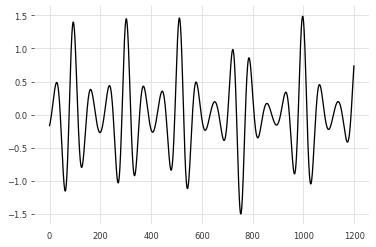

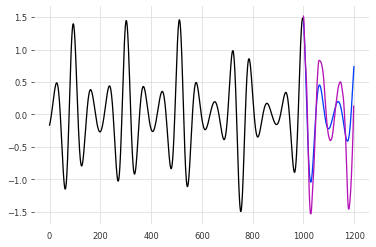

In [142]:
plt.plot(t_train, y_train)
plt.plot(t_train_val, y_train_val)
plt.plot(t_train_val[:-1], all_predictions["TransformerModel"])

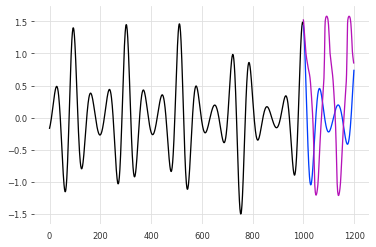

In [140]:
plt.plot(t_train, y_train)
plt.plot(t_train_val, y_train_val)
plt.plot(t_train_val[:-1], all_predictions["TransformerModel"])

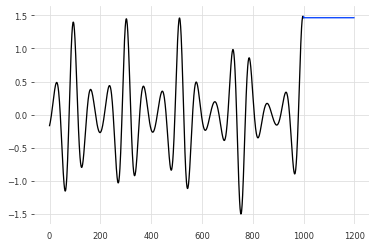

In [124]:
plt.plot(t_train, y_train)
# plt.plot(all_predictions)

# for pred in all_predictions:
plt.plot(t_test[:-1], y_pred)

In [ ]:

names = 
models =
metrics =
benchmark_forecasts = pd.DataFrame

In [ ]:
ModelMode.ADDITIVE

In [3]:
import darts.models

Importing plotly failed. Interactive plots will not work.


In [95]:
all_predictions[0]

IndexError: list index out of range

In [62]:
len(val)

199

In [175]:
 train_data[split_point:].shape

(200,)

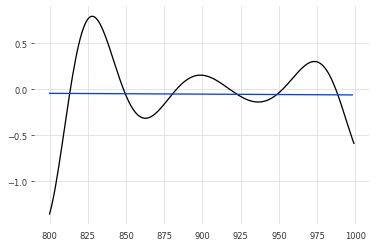

In [190]:
plt.plot(np.arange(split_point, 1000), train_data[split_point:])
plt.plot(np.arange(split_point, 999), all_predictions[-4])

ValueError: x and y must have same first dimension, but have shapes (1000,) and (1200,)

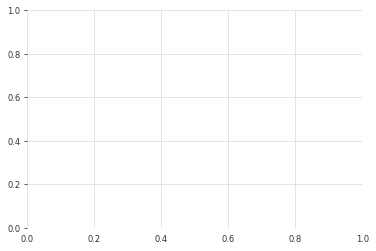

In [123]:
plt.plot(np.arange(1000), train_data)
# plt.plot(all_predictions)

for pred in all_predictions:
    plt.plot(np.arange(split_point, 999), pred)
    


In [34]:
?train_df.split_after

Signature:
train_df.split_after(
    split_point: Union[pandas._libs.tslibs.timestamps.Timestamp, float, int],
) -> Tuple[ForwardRef('TimeSeries'), ForwardRef('TimeSeries')]
Docstring:
Splits the TimeSeries in two, after a provided `split_point`.

Parameters
----------
split_point
    A timestamp, float or integer. If float, represents the proportion of the dataset to include in the
    first TimeSeries (must be between 0.0 and 1.0). If integer, represents the index position after
    which the split is performed. If timestamp, it will be contained in the first TimeSeries, but not
    in the second one. The timestamp may not appear in the original TimeSeries index.

Returns
-------
Tuple[TimeSeries, TimeSeries]
    A tuple of two time series. The first time series contains the first samples up to the `split_point`,
    and the second contains the remaining ones.
File:      ~/miniconda3/envs/nn/lib/python3.8/site-packages/darts/timeseries.py
Type:      method


In [29]:
pd.DataFrame(np.vstack([np.arange(len(train_data)), train_data]).T, columns=["time", "vals"])


,0,1
0,0.0,0.353756
1,1.0,0.353819
2,2.0,0.350929
3,3.0,0.344973
4,4.0,0.335860
...,...,...
995,995.0,-0.389878
996,996.0,-0.441711
997,997.0,-0.492419
998,998.0,-0.541439


In [9]:
from darts import TimeSeries
import pandas as pd
# series = TimeSeries.from_dataframe(df, 'Month', '#Passengers')

                                      0
1970-01-01 00:00:00.000000000  0.353756
1970-01-01 00:00:00.000000001  0.353819
1970-01-01 00:00:00.000000002  0.350929
1970-01-01 00:00:00.000000003  0.344973
1970-01-01 00:00:00.000000004  0.335860
...                                 ...
1970-01-01 00:00:00.000000995 -0.389878
1970-01-01 00:00:00.000000996 -0.441711
1970-01-01 00:00:00.000000997 -0.492419
1970-01-01 00:00:00.000000998 -0.541439
1970-01-01 00:00:00.000000999 -0.588207

[1000 rows x 1 columns]
Freq: N

In [2]:
load_continuous(subsets="train").to_array().shape

(131, 1000)

In [3]:
load_continuous(subsets="test").to_array().shape

(131, 200)

In [4]:
load_continuous(subsets="val").to_array().shape

(131, 200)